In [230]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from typing import Tuple, Optional
from datetime import datetime

In [231]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.loss")
warnings.filterwarnings("ignore", category=FutureWarning)

In [232]:
import sys
import pandas as pd

In [233]:
from pathlib import Path

project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

    
from src.utils.paths import DATASET_PATH
from src.data.processing import preprocess_data, add_daily_features
from src.features.fourier_transform import fft_features
from src.dataset.windowing import build_train_df

In [234]:
data = pd.read_csv(DATASET_PATH)

## 데이터 변환: 일자별로 F1~F48 컬럼 생성
- F1: 0시 급속, F2: 0시 완속
- F3: 1시 급속, F4: 1시 완속
- ...
- F47: 23시 급속, F48: 23시 완속

In [235]:
df = data.copy()

df['일자'] = pd.to_datetime(df['일자'])

fast_df = df[df['충전방식'] == '급속'].copy()
slow_df = df[df['충전방식'] == '완속'].copy()

hourly_cols = [f'{h}시' for h in range(24)]

fast_df = fast_df.sort_values('일자').set_index('일자')[hourly_cols]
slow_df = slow_df.sort_values('일자').set_index('일자')[hourly_cols]

new_data = []

all_dates = sorted(set(fast_df.index) | set(slow_df.index))

for date in all_dates:
    row = {'일자': date}
    
    for hour in range(24):
        hour_col = f'{hour}시'
        
        f_idx_fast = hour * 2 + 1
        if date in fast_df.index:
            row[f'F{f_idx_fast}'] = fast_df.loc[date, hour_col]
        else:
            row[f'F{f_idx_fast}'] = 0
        
        f_idx_slow = hour * 2 + 2
        if date in slow_df.index:
            row[f'F{f_idx_slow}'] = slow_df.loc[date, hour_col]
        else:
            row[f'F{f_idx_slow}'] = 0
    
    new_data.append(row)

df = pd.DataFrame(new_data)

df = df.sort_values('일자').reset_index(drop=True)

df

,일자,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F39,F40,F41,F42,F43,F44,F45,F46,F47,F48
0,2020-01-01,2800,700,3200,805,2320,791,1600,259,1520,...,8160,903,6880,1218,6080,1197,4360,1148,3800,1078
1,2020-01-02,1400,413,1240,413,1000,133,680,133,880,...,10040,1449,7800,1253,5600,1358,4800,1386,3840,1680
2,2020-01-03,2240,539,1480,525,1240,210,640,196,920,...,9160,1365,7640,1309,6080,1302,5520,1470,4880,2030
3,2020-01-04,2360,686,2040,364,1440,217,1160,217,1200,...,8080,980,6800,917,4880,1036,3880,987,4160,1477
4,2020-01-05,1640,469,1640,294,1280,294,920,175,1200,...,7400,1162,6640,1274,4960,1246,3680,952,2960,1057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,2024-09-26,2760,658,2240,378,1640,224,1200,182,2600,...,14480,2436,12240,1673,8480,1925,7600,1806,4560,1785
1731,2024-09-27,3080,602,1800,588,1680,245,1760,161,2960,...,15080,2359,12560,1960,9360,1890,6640,1743,4880,1344
1732,2024-09-28,3120,735,2080,714,2320,322,2120,245,3240,...,12760,1911,9760,1792,8240,1736,6440,1694,3520,1645
1733,2024-09-29,2440,749,2240,434,1560,315,1520,259,2120,...,11160,1904,10280,1820,6400,1953,5720,1351,3520,924


## 일별 총 충전량 계산
급속(홀수 F 컬럼)과 완속(짝수 F 컬럼)의 일별 합계 추가

In [236]:
fast_cols = [f'F{i}' for i in range(1, 49, 2)]  # F1, F3, F5, ..., F47

slow_cols = [f'F{i}' for i in range(2, 49, 2)]  # F2, F4, F6, ..., F48

df['daily_fast'] = df[fast_cols].sum(axis=1)

df['daily_slow'] = df[slow_cols].sum(axis=1)

df[['일자', 'daily_fast', 'daily_slow']].head(10)

,일자,daily_fast,daily_slow
0,2020-01-01,169120,16387
1,2020-01-02,155960,16240
2,2020-01-03,160400,18025
3,2020-01-04,152600,14357
4,2020-01-05,138520,15904
5,2020-01-06,144440,16814
6,2020-01-07,137000,17199
7,2020-01-08,155240,18781
8,2020-01-09,166680,18382
9,2020-01-10,168480,19201


## 로그 변환 (daily_fast, daily_slow)
타겟 변수의 분포를 정규화하기 위해 ln(1+x) 변환 적용

In [237]:
# 로그 변환 전 원본 값 저장 (나중에 역변환 시 필요하면 사용)
df['daily_fast_original'] = df['daily_fast'].copy()
df['daily_slow_original'] = df['daily_slow'].copy()

# ln(1+x) 변환 적용
df['daily_fast'] = np.log1p(df['daily_fast'])
df['daily_slow'] = np.log1p(df['daily_slow'])

# F1~F48 모든 컬럼에 로그 변환 적용
for i in range(1, 49):
    df[f'F{i}'] = np.log1p(df[f'F{i}'])

## MinMax Scaling (F1~F48)
시간별 충전량 피처들을 0~1 범위로 정규화

In [238]:
from sklearn.preprocessing import MinMaxScaler

# F1~F48 컬럼 리스트
feature_cols = [f'F{i}' for i in range(1, 49)]

# MinMaxScaler 초기화
scaler = MinMaxScaler()

# F1~F48 컬럼만 스케일링 (0~1 범위로 변환)
df[feature_cols] = scaler.fit_transform(df[feature_cols])
df[["daily_fast"]] = scaler.fit_transform(df[["daily_fast"]])
df[["daily_slow"]] = scaler.fit_transform(df[["daily_slow"]])

In [240]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=48, hidden_dim=50, output_days=7, num_layers=2, dropout=dropout):
        """
        Args:
            input_dim: 입력 피처 차원 (48: F1~F48)
            hidden_dim: LSTM 은닉층 크기
            output_days: 예측할 일수 (7일)
            num_layers: LSTM 레이어 수
            dropout: 드롭아웃 비율
        """
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_days * 2)
        self.output_days = output_days

    def forward(self, x):
        out, _ = self.lstm(x)
        
        out = out[:, -1, :]
        
        out = self.fc(out)
        
        out = out.view(-1, self.output_days, 2)
        
        return out

In [241]:
class KeriDataset(Dataset):
    def __init__(self, df, input_len=28, output_len=7):
        """
        Args:
            df: 일자, F1~F48, daily_fast, daily_slow 컬럼을 가진 DataFrame
            input_len: 입력으로 사용할 과거 일수 (기본 28일)
            output_len: 예측할 미래 일수 (기본 7일)
        """
        self.data = []
        self.labels = []

        df = df.sort_values('일자').reset_index(drop=True)
        
        feature_cols = [f'F{i}' for i in range(1, 49)]
        feature_data = df[feature_cols].values
        
        target_data = df[['daily_fast', 'daily_slow']].values
        
        for i in range(len(df) - input_len - output_len + 1):
            self.data.append(feature_data[i:i+input_len])
            
            self.labels.append(target_data[i+input_len:i+input_len+output_len])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.data[idx], dtype=torch.float32),      # (28, 48)
            torch.tensor(self.labels[idx], dtype=torch.float32)     # (7, 2)
        )

In [242]:
# 평가 함수
def calculate_accuracy(y_true, y_pred):
    """
    정규화된 MAE를 기반으로 Accuracy 계산
    """
    mae = np.mean(np.abs(y_true - y_pred))  # 평균 절대 오차
    mean_true = np.mean(y_true)  # 실제 값의 평균  
    normalized_mae = mae / (mean_true + 1e-8)  # 정규화 (0으로 나누기 방지)
    accuracy = 1 - normalized_mae
    return max(0, accuracy) * 100 # Accuracy 하한을 0으로 제한

def evaluate_model(model, test_loader, device, target_scaler):
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    y_true = np.array(all_targets)
    y_pred = np.array(all_predictions)

    # 역정규화
    y_true_original = target_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_original = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    # 평가 지표
    mae = np.mean(np.abs(y_true_original - y_pred_original))
    mse = mean_squared_error(y_true_original, y_pred_original)
    r2 = r2_score(y_true_original, y_pred_original)
    accuracy = calculate_accuracy(y_true_original, y_pred_original)
    
    # 피어슨 상관계수
    pearson_corr, _ = pearsonr(y_true_original, y_pred_original)

    return mae, mse, r2, accuracy, pearson_corr, y_true_original, y_pred_original

In [243]:
# 시각화 함수
def plot_loss_per_epoch(train_losses, val_losses, filename=f"./final_all/LSTM/{num_of_try}/loss_per_epoch.png"):
    plt.figure(figsize=(13, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='b', label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o', color='r', label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.savefig(filename, dpi=600)
    plt.close()

def plot_predictions_vs_actual(y_true, y_pred, filename=f"./final_all/LSTM/{num_of_try}/predictions_vs_actual.png"):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, color='blue', label='Actual', alpha=0.7)
    plt.plot(y_pred, color='red', label='Predicted', alpha=0.6)
    plt.title('Actual vs Predicted')
    plt.xlabel('Index')
    plt.ylabel('Total Amount')
    plt.legend()
    plt.savefig(filename, dpi=600)
    plt.close()

def plot_scatter_actual_vs_predicted(y_true, y_pred, filename=f"./final_all/LSTM/{num_of_try}/scatter_actual_vs_predicted.png"):
    plt.figure(figsize=(15, 15))
    plt.scatter(y_true, y_pred, alpha=0.8, color='black')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', linewidth=3)
    plt.title('Scatter Plot: Actual vs Predicted', fontsize=25)
    plt.xlabel('Normalized Total Amount', fontsize=17)
    plt.ylabel('Predicted Total Amount', fontsize=17)
    plt.grid(True)
    plt.savefig(filename, bbox_inches='tight', dpi=600)
    plt.close()

def plot_scatter_actual_vs_predicted2(y_true, y_pred, filename=f"./final_all/LSTM/{num_of_try}/scatter_actual_vs_predicted.png"):
    plt.figure(figsize=(15, 15))
    plt.scatter(y_true, y_pred, alpha=0.8, color='purple')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='black', linestyle='--', linewidth=4)
    plt.title('Scatter Plot: Actual vs Predicted', fontsize=25)
    plt.xlabel('Normalized Total Amount', fontsize=17)
    plt.ylabel('Predicted Total Amount', fontsize=17)
    plt.grid(True)
    plt.savefig(filename, bbox_inches='tight', dpi=600)
    plt.close()

def plot_scatter_actual_vs_predicted3(y_true, y_pred, filename=f"./final_all/LSTM/{num_of_try}/scatter_actual_vs_predicted.png"):
    plt.figure(figsize=(15, 15))
    plt.scatter(y_true, y_pred, alpha=1, color='purple')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='green', linestyle='-', linewidth=3)
    plt.title('Scatter Plot: Actual vs Predicted', fontsize=25)
    plt.xlabel('Normalized Total Amount', fontsize=20)
    plt.ylabel('Predicted Total Amount', fontsize=20)
    plt.grid(True)
    plt.savefig(filename, bbox_inches='tight', dpi=600)
    plt.close()

def plot_scatter_actual_vs_predicted4(y_true, y_pred, filename=f"./final_all/LSTM/{num_of_try}/scatter_actual_vs_predicted.png"):
    plt.figure(figsize=(15, 15))
    plt.scatter(y_true, y_pred, alpha=1, color='purple')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='black', linestyle='-', linewidth=3)
    plt.title('Scatter Plot: Actual vs Predicted', fontsize=25)
    plt.xlabel('Normalized Total Amount', fontsize=20)
    plt.ylabel('Predicted Total Amount', fontsize=20)
    plt.grid(True)
    plt.savefig(filename, bbox_inches='tight', dpi=600)
    plt.close()

def plot_scatter_actual_vs_predicted5(y_true, y_pred, filename=f"./final_all/LSTM/{num_of_try}/scatter_actual_vs_predicted.png"):
    plt.figure(figsize=(15, 15))
    plt.scatter(y_true, y_pred, alpha=1, color='orange')  # 점 색상을 밝은 주황색으로 변경
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='black', linestyle='-', linewidth=3)
    plt.title('Scatter Plot: Actual vs Predicted', fontsize=25)
    plt.xlabel('Normalized Total Amount', fontsize=20)
    plt.ylabel('Predicted Total Amount', fontsize=20)
    plt.grid(True)
    plt.savefig(filename, bbox_inches='tight', dpi=600)
    plt.close()

In [244]:
df

,일자,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F43,F44,F45,F46,F47,F48,daily_fast,daily_slow,daily_fast_original,daily_slow_original
0,2020-01-01,0.476517,0.766975,0.677947,0.824724,0.688053,0.972712,0.615550,0.774710,0.511685,...,0.355517,0.341840,0.323789,0.339155,0.462554,0.394782,0.295880,0.229186,169120,16387
1,2020-01-02,0.212811,0.583023,0.309077,0.589453,0.432573,0.450154,0.386473,0.594698,0.317411,...,0.321714,0.423794,0.371812,0.463294,0.467406,0.662382,0.246932,0.222185,155960,16240
2,2020-01-03,0.391613,0.675831,0.377904,0.674008,0.497861,0.583687,0.370251,0.699354,0.333208,...,0.355517,0.396445,0.441625,0.502068,0.578455,0.776542,0.263894,0.303211,160400,18025
3,2020-01-04,0.411468,0.759929,0.502758,0.544968,0.543252,0.593286,0.529435,0.726862,0.427647,...,0.265147,0.248041,0.265530,0.239604,0.504492,0.584702,0.233773,0.126429,152600,14357
4,2020-01-05,0.272998,0.627337,0.417840,0.469776,0.507498,0.682249,0.467376,0.668742,0.427647,...,0.271830,0.367894,0.239097,0.215820,0.346815,0.382919,0.175280,0.205940,138520,15904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,2024-09-26,0.471042,0.745395,0.539149,0.558260,0.582734,0.602581,0.538512,0.679334,0.702565,...,0.492277,0.650422,0.601359,0.637731,0.547030,0.698952,0.599137,0.594253,279360,26215
1731,2024-09-27,0.512784,0.714375,0.454058,0.713958,0.590050,0.628825,0.641076,0.646231,0.748684,...,0.532863,0.638502,0.533904,0.614329,0.578455,0.527787,0.629507,0.566586,293760,25298
1732,2024-09-28,0.517694,0.783994,0.510313,0.782417,0.688053,0.708919,0.690923,0.759679,0.780830,...,0.480475,0.583293,0.518627,0.595537,0.427092,0.649682,0.545902,0.525758,255800,24003
1733,2024-09-29,0.424152,0.790575,0.539149,0.606927,0.567552,0.702474,0.601813,0.774710,0.629985,...,0.376601,0.659802,0.459403,0.446440,0.427092,0.301833,0.459945,0.497609,221880,23149


In [256]:
# 시간 기반 데이터 분리
# Train: 2023-12-31까지, Val: 2024-01-01 ~ 2024-06-30, Test: 2024-07-01 ~ 2024-09-30

train_df = df[df['일자'] <= '2023-12-31'].copy()
val_df = df[(df['일자'] >= '2024-01-01') & (df['일자'] <= '2024-06-30')].copy()
test_df = df[(df['일자'] >= '2024-07-01') & (df['일자'] <= '2024-09-30')].copy()

print(f"Train 데이터: {len(train_df)}일 ({train_df['일자'].min()} ~ {train_df['일자'].max()})")
print(f"Val 데이터: {len(val_df)}일 ({val_df['일자'].min()} ~ {val_df['일자'].max()})")
print(f"Test 데이터: {len(test_df)}일 ({test_df['일자'].min()} ~ {test_df['일자'].max()})")

Train 데이터: 1461일 (2020-01-01 00:00:00 ~ 2023-12-31 00:00:00)
Val 데이터: 182일 (2024-01-01 00:00:00 ~ 2024-06-30 00:00:00)
Test 데이터: 92일 (2024-07-01 00:00:00 ~ 2024-09-30 00:00:00)


In [257]:
# Dataset 생성
train_dataset = KeriDataset(train_df, input_len=28, output_len=7)
val_dataset = KeriDataset(val_df, input_len=28, output_len=7)
test_dataset = KeriDataset(test_df, input_len=28, output_len=7)

print(f"\nDataset 샘플 수:")
print(f"  Train: {len(train_dataset)}개")
print(f"  Val: {len(val_dataset)}개")
print(f"  Test: {len(test_dataset)}개")

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Dataset 샘플 수:
  Train: 1427개
  Val: 148개
  Test: 58개


In [269]:
# GPU 설정 확인
print("CUDA 사용 가능:", torch.cuda.is_available())
print("CUDA 버전:", torch.version.cuda)
print("PyTorch 버전:", torch.__version__)

if torch.cuda.is_available():
    print("GPU 이름:", torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print("⚠️ CUDA를 찾을 수 없습니다. CPU를 사용합니다.")
    device = torch.device('cpu')

print(f"사용 Device: {device}\n")

criterion = nn.MSELoss()

CUDA 사용 가능: False
CUDA 버전: None
PyTorch 버전: 2.9.1+cpu
⚠️ CUDA를 찾을 수 없습니다. CPU를 사용합니다.
사용 Device: cpu



In [279]:
# 모델 학습 (GPU 활용)
model = LSTMModel(input_dim=48, hidden_dim=100, output_days=7, num_layers=2, dropout=dropout)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 10
patience_counter = 0

print(f"\n{'='*60}")
print(f"Device: {device}")
print(f"Epochs: {num_epochs}, Learning Rate: {learning_rate}")
print(f"{'='*60}\n")

for epoch in range(1, num_epochs + 1):
    # Train
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch:2d}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch}")
        model.load_state_dict(best_model_state)
        break

print(f"\n학습 완료!")
print(f"최종 Train Loss: {train_losses[-1]:.6f}")
print(f"최종 Val Loss: {val_losses[-1]:.6f}")


Device: cpu
Epochs: 100, Learning Rate: 0.001

Epoch  5/100 | Train Loss: 0.004748 | Val Loss: 0.012930
Epoch 10/100 | Train Loss: 0.003818 | Val Loss: 0.004641
Epoch 15/100 | Train Loss: 0.003590 | Val Loss: 0.004427
Epoch 20/100 | Train Loss: 0.003567 | Val Loss: 0.003931

Early stopping at epoch 22

학습 완료!
최종 Train Loss: 0.003314
최종 Val Loss: 0.005283


In [278]:
# 하이퍼파라미터
num_of_try = 23
num_epochs = 100
learning_rate = 0.001
num_folds = 5
dropout = 0.3

Test Metrics (scaled)
MAE  : 0.067063
RMSE : 0.085921
MSE  : 0.007382
R2   : -1.015467
Accuracy (scaled): 88.84%

Test Metrics (inverse-transformed, original units)
MAE  (fast) : 26477.3750
RMSE (fast) : 35913.0113
MAE  (slow) : 2697.8350
RMSE (slow) : 3168.8676
MAE  (all)  : 14587.6055
RMSE (all)  : 25493.0001
R2   (all)  : 0.9619



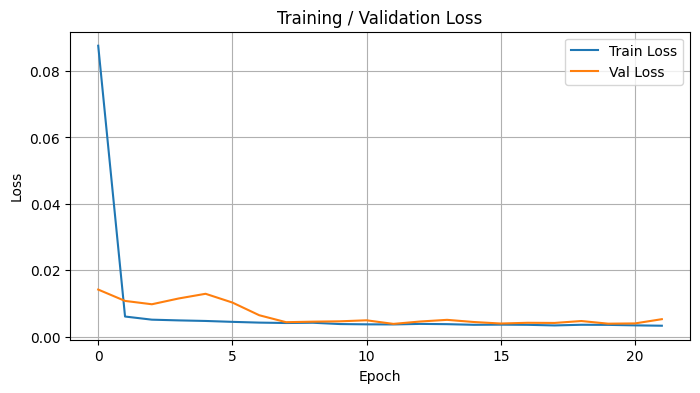

Sample predictions vs targets (first 10 steps, flattened):
y_true=0.6535, y_pred=0.6202
y_true=0.6299, y_pred=0.6653
y_true=0.6770, y_pred=0.6484
y_true=0.6495, y_pred=0.6796
y_true=0.6831, y_pred=0.6471
y_true=0.6464, y_pred=0.6852
y_true=0.6990, y_pred=0.6487
y_true=0.6848, y_pred=0.6983
y_true=0.7208, y_pred=0.6531
y_true=0.6283, y_pred=0.6982


In [280]:
# Test 평가 및 학습 곡선 플롯

# Test 평가 (스케일된 값 기준)
model.eval()
all_targets = []
all_preds = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        all_targets.append(targets.cpu().numpy())
        all_preds.append(outputs.cpu().numpy())

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_true = np.concatenate(all_targets, axis=0)
y_pred = np.concatenate(all_preds, axis=0)

mae = mean_absolute_error(y_true.reshape(-1, 1), y_pred.reshape(-1, 1))
mse = mean_squared_error(y_true.reshape(-1, 1), y_pred.reshape(-1, 1))
rmse = mse ** 0.5
r2 = r2_score(y_true.reshape(-1, 1), y_pred.reshape(-1, 1))
accuracy = calculate_accuracy(y_true, y_pred)

print("Test Metrics (scaled)")
print(f"MAE  : {mae:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"MSE  : {mse:.6f}")
print(f"R2   : {r2:.6f}")
print(f"Accuracy (scaled): {accuracy:.2f}%\n")

# --- 역변환 후 실제 단위 MAE/RMSE 계산 ---
# 스케일러 재구성 (로그 변환된 타깃에 대해 MinMax 피팅)
fast_log = np.log1p(df['daily_fast_original'].values.reshape(-1, 1))
slow_log = np.log1p(df['daily_slow_original'].values.reshape(-1, 1))
scaler_fast = MinMaxScaler().fit(fast_log)
scaler_slow = MinMaxScaler().fit(slow_log)

# 스케일된 예측/정답 분리
true_fast_scaled = y_true[:, :, 0]
true_slow_scaled = y_true[:, :, 1]
pred_fast_scaled = y_pred[:, :, 0]
pred_slow_scaled = y_pred[:, :, 1]

# 역스케일링 후 원 단위 복원
true_fast_log = scaler_fast.inverse_transform(true_fast_scaled.reshape(-1, 1)).reshape(true_fast_scaled.shape)
pred_fast_log = scaler_fast.inverse_transform(pred_fast_scaled.reshape(-1, 1)).reshape(pred_fast_scaled.shape)
true_slow_log = scaler_slow.inverse_transform(true_slow_scaled.reshape(-1, 1)).reshape(true_slow_scaled.shape)
pred_slow_log = scaler_slow.inverse_transform(pred_slow_scaled.reshape(-1, 1)).reshape(pred_slow_scaled.shape)

true_fast_orig = np.expm1(true_fast_log)
pred_fast_orig = np.expm1(pred_fast_log)
true_slow_orig = np.expm1(true_slow_log)
pred_slow_orig = np.expm1(pred_slow_log)

# 채널별 및 전체 지표
mae_fast_orig = mean_absolute_error(true_fast_orig.flatten(), pred_fast_orig.flatten())
rmse_fast_orig = mean_squared_error(true_fast_orig.flatten(), pred_fast_orig.flatten()) ** 0.5
mae_slow_orig = mean_absolute_error(true_slow_orig.flatten(), pred_slow_orig.flatten())
rmse_slow_orig = mean_squared_error(true_slow_orig.flatten(), pred_slow_orig.flatten()) ** 0.5

true_all_orig = np.concatenate([true_fast_orig.flatten(), true_slow_orig.flatten()])
pred_all_orig = np.concatenate([pred_fast_orig.flatten(), pred_slow_orig.flatten()])
mae_all_orig = mean_absolute_error(true_all_orig, pred_all_orig)
rmse_all_orig = mean_squared_error(true_all_orig, pred_all_orig) ** 0.5
r2_all_orig = r2_score(true_all_orig, pred_all_orig)

print("Test Metrics (inverse-transformed, original units)")
print(f"MAE  (fast) : {mae_fast_orig:.4f}")
print(f"RMSE (fast) : {rmse_fast_orig:.4f}")
print(f"MAE  (slow) : {mae_slow_orig:.4f}")
print(f"RMSE (slow) : {rmse_slow_orig:.4f}")
print(f"MAE  (all)  : {mae_all_orig:.4f}")
print(f"RMSE (all)  : {rmse_all_orig:.4f}")
print(f"R2   (all)  : {r2_all_orig:.4f}\n")

# 학습/검증 손실 곡선
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# 예측 vs 실제 (첫 10개 타임스텝 예시)
print("Sample predictions vs targets (first 10 steps, flattened):")
for i in range(min(10, len(y_true.flatten()))):
    print(f"y_true={y_true.flatten()[i]:.4f}, y_pred={y_pred.flatten()[i]:.4f}")
